In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
from tensorflow.examples.tutorials.mnist import input_data
import ipynb.fs.full.Structural_Perturbations as SP

tf.logging.set_verbosity(tf.logging.ERROR)

In [21]:
# Load training and eval data
mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
acc_track = []
pred_diff = []

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


0.7803922


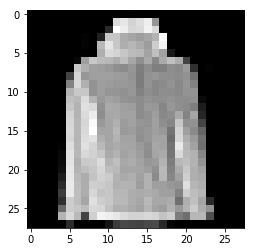

In [4]:
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [15]:
eval_data = Scaling(eval_data,1.5)

In [26]:
eval_data = SP.Exposure(eval_data,+60)

In [46]:
eval_data = Rotation(eval_data,10)

In [69]:
eval_data = Translation(eval_data,2)

1.0


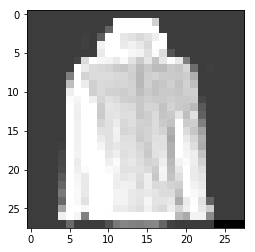

In [27]:
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [7]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=8,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  #print(pool2.shape)
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  #print(pool2_flat.shape)
  dense = tf.layers.dense(inputs=pool2_flat, units=64, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)
  #print(logits.shape)
  #temp = tf.nn.top_k(input=logits,k=1,sorted=True,name=None)
  #print(temp[0])
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      
      #"classes": temp,
      "classes":tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"]),
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [22]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/fmnist_convnet_model_small6")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [23]:
def current_loss(flag):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    if flag:
        print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    if flag:
        print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()
    return a[1],d[1]

In [24]:
print("started\n")
# Train the model
while 1:
    
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=128,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=[logging_hook])
    curr_result = current_loss(0)
    print(curr_result)
    if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
       break
    #print(curr_result)
    
print ("Finished")

started

Training
(0.8870364, 0.8754)
Training
(0.9022545, 0.8837)
Training


KeyboardInterrupt: 

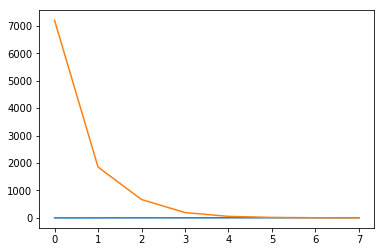

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [28]:
SP.Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.90081817, 'loss': 0.2539612, 'global_step': 2001}
######### Test accuracy #############
 {'accuracy': 0.412, 'loss': 1.890078, 'global_step': 2001}


(('accuracy', 0.90081817),
 ('loss', 0.2539612),
 ('global_step', 2001),
 ('accuracy', 0.412),
 ('loss', 1.890078),
 ('global_step', 2001))